In [ ]:
from pathlib import Path

from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.earth_params import seconds_per_year

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd

# ===================================
# 1. Create FAIR instance
# Thonhill 2021 is to reproduce AR6-like simulations
# ===================================

f = FAIR(ch4_method='thornhill2021')

# ===================================
# 2. Define the model
# ===================================

# define time horizons
# need to change volcano stuff to increase time
start_year = 1750
end_year = 2300
n_years = end_year - start_year + 1
f.define_time(start_year, end_year, 1)

# Define scenarios
# see Hausfather and Peters (2020), 'business as usual' scenario is misleading
# naratives of SSPs are here: https://www.sciencedirect.com/science/article/pii/S0959378016300681#sec0025
# first number in SSP is the narrative (1,2,3,4,5), higher the number the worse the scenario
# last two numbers are the ERF at 2100 (see figures in https://gmd.copernicus.org/articles/9/3461/2016/gmd-9-3461-2016.pdf)
# So... 1.9, 2.6, 3.4, 4.5, 6.0, 7.0, 8.5 W/m2
# i.e. SSP119 is the best case scenario and SSP585 is worst case (but not likely at all)
# SSP1-1.9 --> mitigation required to meet Paris goals
# SSP2-4.5 --> modest mitigation (likely)
# SSP4-6.0 --> weak migitation (likely)
# SSP3-7.0 --> average no policy (unlikely)
scenarios = ['ssp119', 'ssp245', 'ssp460', 'ssp370']
f.define_scenarios(scenarios)

# define configurations
# these describe climate response and species response parameters
# these effectively setup the different scenarios
fl = Path("../data/calibration/output/fair-2.1.3/v1.4/all-2022/calibrations/4xCO2_cummins_ebm3_cmip6.csv")
df = pd.read_csv(fl)
models = df['model'].unique()
configs = []

for imodel, model in enumerate(models):
    for run in df.loc[df['model']==model, 'run']:
        configs.append(f"{model}_{run}")
        
f.define_configs(configs)

# define species included in the model
# here I am using the default set of species and props
species, properties = read_properties()
f.define_species(species, properties)

# ===================================
# 3. modify the run control options
# here is where you would modify the run
# ===================================

# ===================================
# 4. Create input output dataArrays
# ===================================

f.allocate()

# ===================================
#  5. Fill in the data
# ===================================

#f.species_configs["baseline_emissions"].sel(specie="CH4", config="MPI-ESM1-2-HR_r1i1p1f1")

# wait, how is this different than define_species?
f.fill_species_configs()

fill(f.species_configs['unperturbed_lifetime'], 10.8537568, specie='CH4')
fill(f.species_configs['baseline_emissions'], 19.01978312, specie='CH4')
fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

# ===================================
## 4.2 fill emissions
# ===================================

# This function automatically selects the emissions, concentration or forcing 
# you want depending on the properties for each of the SSP scenarios defined.
# use calibration data instead?
# this pulls from: https://zenodo.org/records/4589756
f.fill_from_rcmip()

# error prone when keep redefining fl
fl = Path("../data/calibration/data/forcing/volcanic_ERF_monthly_-950001-201912.csv")
df_volcanic = pd.read_csv(fl, index_col='year')

# overwrite volcanic
n_years_to_fill = 2021 - start_year
volcanic_forcing = np.zeros(n_years)
volcanic_forcing[:n_years_to_fill] = df_volcanic[(start_year - 1):].groupby(np.ceil(df_volcanic[(start_year - 1):].index) // 1).mean().squeeze().values
fill(f.forcing, volcanic_forcing[:, None, None], specie="Volcanic")  # sometimes need to expand the array

initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

# ===================================
## 4.3 fill climate configs 
# ===================================

fl = Path("../data/calibration/output/fair-2.1.3/v1.4/all-2022/calibrations/4xCO2_cummins_ebm3_cmip6.csv")

df = pd.read_csv(fl)
models = df['model'].unique()

seed = 1355763

for config in configs:
    model, run = config.split('_')
    condition = (df['model']==model) & (df['run']==run)
    fill(f.climate_configs['ocean_heat_capacity'], df.loc[condition, 'C1':'C3'].values.squeeze(), config=config)
    fill(f.climate_configs['ocean_heat_transfer'], df.loc[condition, 'kappa1':'kappa3'].values.squeeze(), config=config)
    fill(f.climate_configs['deep_ocean_efficacy'], df.loc[condition, 'epsilon'].values[0], config=config)
    fill(f.climate_configs['gamma_autocorrelation'], df.loc[condition, 'gamma'].values[0], config=config)
    fill(f.climate_configs['sigma_eta'], df.loc[condition, 'sigma_eta'].values[0], config=config)
    fill(f.climate_configs['sigma_xi'], df.loc[condition, 'sigma_xi'].values[0], config=config)
    fill(f.climate_configs['stochastic_run'], True, config=config)
    fill(f.climate_configs['use_seed'], True, config=config)
    fill(f.climate_configs['seed'], seed, config=config)

    # what exactly does the seed do?
    seed = seed + 399

# ===================================
# 5. run model
# ===================================
f.run()

/var/folders/ks/g14k9qvs16n0xyyjqcrl69000000gn/T/ipykernel_17922/46106664.py:108: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  volcanic_forcing[:n_years_to_fill] = df_volcanic[(start_year - 1):].groupby(np.ceil(df_volcanic[(start_year - 1):].index) // 1).mean().squeeze().values
Running 264 projections in parallel: 100%|██████████| 550/550 [00:00<00:00, 567.16timesteps/s]


In [20]:
df_volcanic.reset_index().year.max()

2019.916666750485

# Plot results

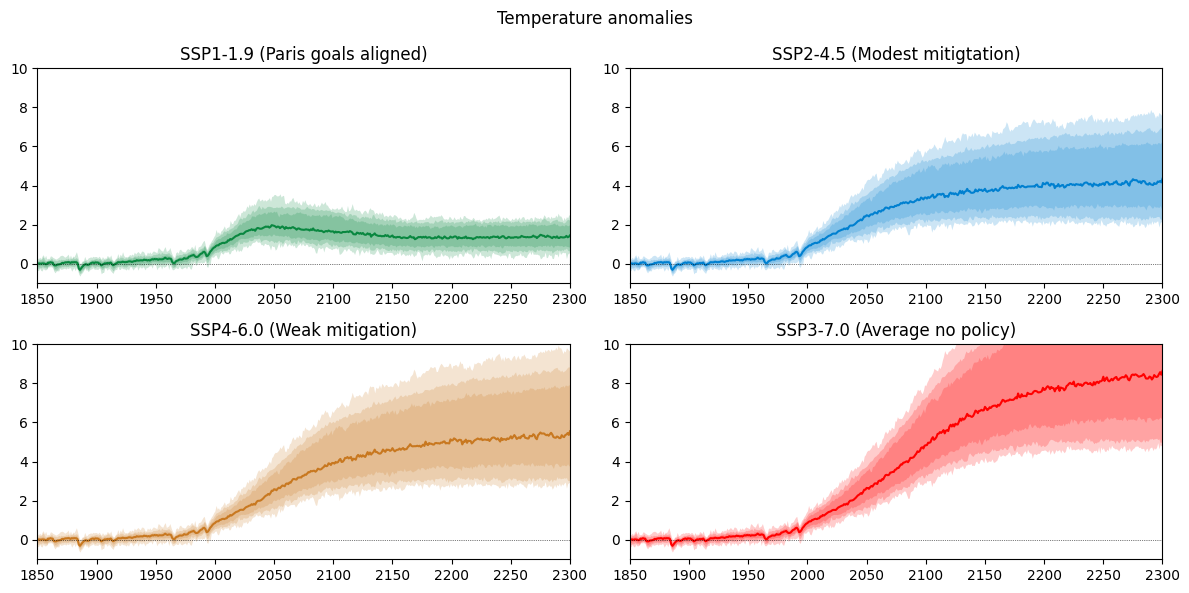

In [28]:
fancy_titles = {
    'ssp119' : 'SSP1-1.9 (Paris goals aligned)',  
    'ssp245' : 'SSP2-4.5 (Modest mitigtation)', 
    'ssp460' : 'SSP4-6.0 (Weak mitigation)',
    'ssp370' : 'SSP3-7.0 (Average no policy)'

} 

colors = {
    'ssp119': '#098740',
    'ssp245': '#0080d0',
    'ssp460': '#c87820',
    'ssp370': '#ff0000',
}


weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

fig, ax = pl.subplots(2, 2, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 2, i % 2].fill_between(
            f.timebounds,
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[1],
                axis=1,
            ),
            color=colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 2, i % 2].plot(
        f.timebounds,
        np.median(
            f.temperature.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                f.temperature.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                weights=weights_51yr,
                axis=0
            ),
            axis=1,
        ),
        color=colors[scenarios[i]],
    )
    ax[i // 2, i % 2].set_xlim(1850, 2300)
    ax[i // 2, i % 2].set_ylim(-1, 10)
    ax[i // 2, i % 2].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 2, i % 2].set_title(fancy_titles[scenarios[i]])

pl.suptitle("Temperature anomalies")
fig.tight_layout()